# Bloomfield Rental Price Forecasting (NJ)

This notebook builds a **rent price prediction model** for apartments in Bloomfield, NJ using a cleaned dataset created from manually collected listings.

**Goal:** predict `Rent_Price_USD` from property characteristics (beds, baths, square feet) and listing attributes (laundry, parking, location zone).

**What you will find here (in order):**
1. Setup & data loading  
2. Cleaning + standardization  
3. Exploratory data analysis (EDA)  
4. Feature engineering (with leakage checks)  
5. Modeling pipeline (One-Hot Encoding + Random Forest, plus model comparison)  
6. Cross-validation + final evaluation  
7. Residual diagnostics + hypothesis test (bias check)  
8. Prediction example + uncertainty range  
9. Saving outputs (CSV) + saving artifacts (deployable model)

> **Note (GitHub users):** update file paths in the *Paths* cell if your folder structure is different.


## 1) Setup


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Optional models (install if needed)
# !pip install xgboost lightgbm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from scipy import stats


## 2) Paths & Data Loading


In [3]:
import os

# --- Update these paths to match your machine ---
PROJECT_DIR = r"C:\Users\19173\Desktop\bloonfield rental apartement price forecasting\derneire 2\Bloomfield-Rental-Price-Forecasting 2"
DATA_DIR    = os.path.join(PROJECT_DIR, "data")
OUTPUT_DIR  = os.path.join(PROJECT_DIR, "Outputs")
ARTIFACT_DIR= os.path.join(PROJECT_DIR, "Notebooks", "artifacts")

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Prefer a repo-friendly path (place your cleaned file in /data)
DATA_PATH_XLSX = os.path.join(DATA_DIR, "bloomfield_clean_data.xlsx")
DATA_PATH_CSV  = os.path.join(DATA_DIR, "bloomfield_rent_clean.csv")

# Load
if os.path.exists(DATA_PATH_XLSX):
    df = pd.read_excel(DATA_PATH_XLSX)
elif os.path.exists(DATA_PATH_CSV):
    df = pd.read_csv(DATA_PATH_CSV)
else:
    raise FileNotFoundError(
        "Could not find cleaned data in /data. Expected one of:\n"
        f"- {DATA_PATH_XLSX}\n- {DATA_PATH_CSV}"
    )

print("Shape:", df.shape)
df.head()


Shape: (492, 9)


,Bedrooms,Bathrooms,Square_Feet,Laundry_Type,Location_Zone,Parking,Room_Ratio,Size_per_Bedroom,Rent_Price_USD
0,1,1.0,725,In-unit,South_East,Premium_fee,0.999001,362.500000,2495
1,2,2.0,980,In-unit,South_East,Premium_fee,0.999500,326.666667,2895
2,1,1.0,600,On-site / Shared,South_East,Standard_fee,0.999001,300.000000,1795
3,1,1.0,900,On-site / Shared,South_East,Standard_fee,0.999001,450.000000,1925
4,2,1.0,950,On-site / Shared,South_East,Standard_fee,1.998002,316.666667,1975


## 3) Cleaning & Standardization


This section applies **minimal, safe cleaning**:
- standardize text categories (trim spaces, consistent naming)
- ensure numeric columns are numeric
- keep the target `Rent_Price_USD` clean and positive


In [4]:
def _clean_str(x):
    return str(x).strip().replace("  ", " ")

# Standardize key categorical columns (only if they exist)
for col in ["Laundry_Type", "Location_Zone", "Parking"]:
    if col in df.columns:
        df[col] = df[col].apply(_clean_str)

# Basic numeric cleanup
for col in ["Bedrooms", "Bathrooms", "Square_Feet", "Rent_Price_USD"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Remove rows with missing target or non-positive rent
df = df.dropna(subset=["Rent_Price_USD"]).copy()
df = df[df["Rent_Price_USD"] > 0].copy()

print("After cleaning:", df.shape)
df[["Bedrooms","Bathrooms","Square_Feet","Rent_Price_USD"]].describe()


After cleaning: (492, 9)


,Bedrooms,Bathrooms,Square_Feet,Rent_Price_USD
count,492.000000,492.000000,492.000000,492.000000
mean,1.646341,1.222053,909.373984,2463.323171
std,0.972602,0.439411,292.913649,636.281342
min,0.000000,1.000000,495.000000,900.000000
25%,1.000000,1.000000,687.750000,1990.000000
50%,2.000000,1.000000,900.000000,2400.000000
75%,2.000000,1.000000,1091.000000,2850.000000
max,4.000000,3.000000,2000.000000,4900.000000


## 4) Exploratory Data Analysis (EDA)


We quickly inspect:
- rent distribution  
- extreme values (top expensive listings)  
- key relationships (sqft, beds, baths, and categorical effects)


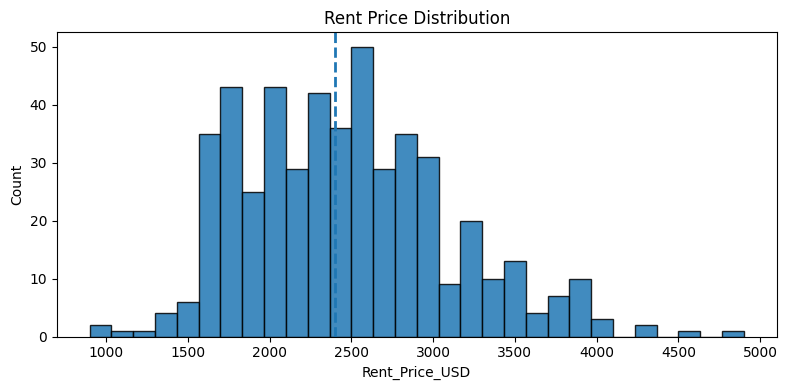

,Rent_Price_USD,Bedrooms,Bathrooms,Square_Feet,Laundry_Type,Location_Zone,Parking
89,4900,4,3.0,2000,Not applicable,North,Included
88,4500,4,3.0,2000,Not applicable,North,Included
87,4300,4,3.0,2000,Not applicable,North,Included
120,4300,4,2.5,1847,Not applicable,South_West,Included
50,4000,3,2.0,1000,Not applicable,North,Included
86,4000,4,3.0,2000,Not applicable,North,Included
97,3995,3,3.0,1172,Not applicable,South_West,Included
31,3900,4,2.5,2000,Not applicable,North,Included
85,3900,4,2.5,2000,Not applicable,North,Included
187,3900,4,2.5,2000,Not applicable,North_South,Included


In [5]:
rent = df["Rent_Price_USD"]

plt.figure(figsize=(8,4))
plt.hist(rent, bins=30, edgecolor="black", alpha=0.85)
plt.axvline(rent.median(), linestyle="--", linewidth=2)
plt.title("Rent Price Distribution")
plt.xlabel("Rent_Price_USD")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Top 10 expensive listings (sanity check)
cols_show = [c for c in ["Rent_Price_USD","Bedrooms","Bathrooms","Square_Feet","Laundry_Type","Location_Zone","Parking"] if c in df.columns]
df.nlargest(10, "Rent_Price_USD")[cols_show]


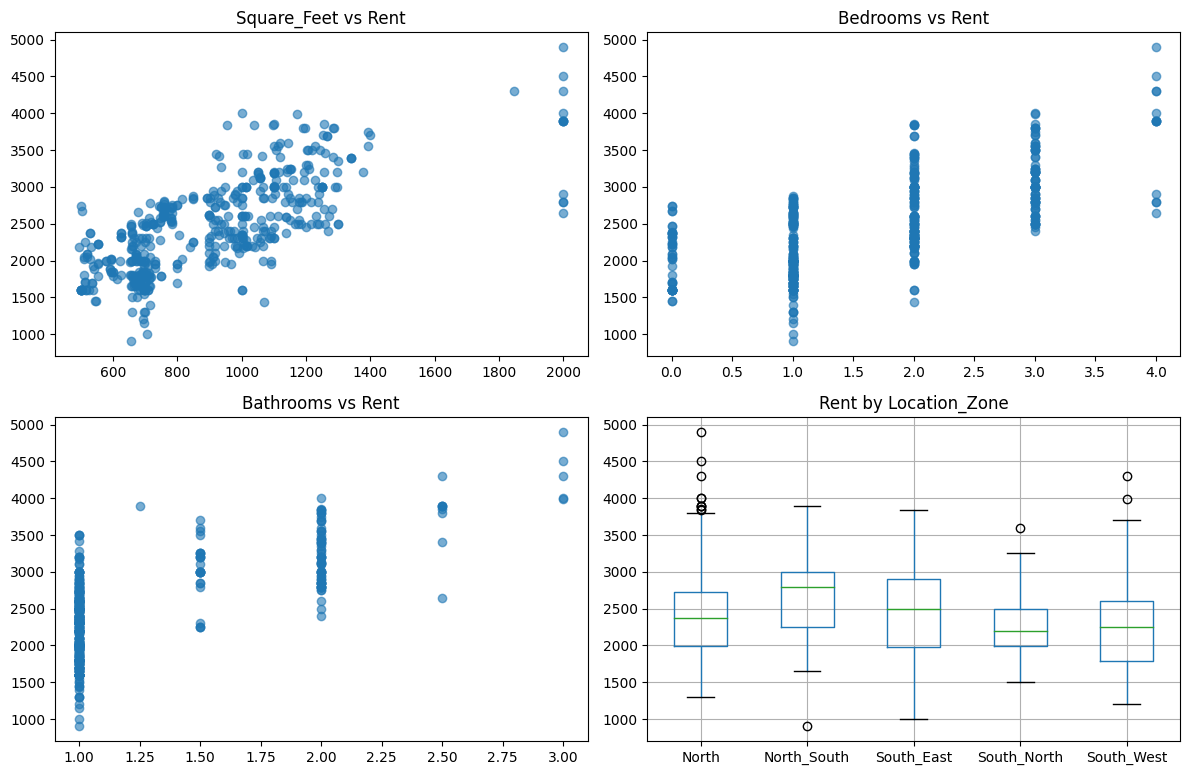

In [6]:
# Quick relationship plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0,0].scatter(df["Square_Feet"], df["Rent_Price_USD"], alpha=0.6)
axes[0,0].set_title("Square_Feet vs Rent")

axes[0,1].scatter(df["Bedrooms"], df["Rent_Price_USD"], alpha=0.6)
axes[0,1].set_title("Bedrooms vs Rent")

axes[1,0].scatter(df["Bathrooms"], df["Rent_Price_USD"], alpha=0.6)
axes[1,0].set_title("Bathrooms vs Rent")

# Boxplot by Location_Zone (if available)
if "Location_Zone" in df.columns:
    df.boxplot(column="Rent_Price_USD", by="Location_Zone", ax=axes[1,1])
    axes[1,1].set_title("Rent by Location_Zone")
    axes[1,1].set_xlabel("")
else:
    axes[1,1].axis("off")

plt.suptitle("")
plt.tight_layout()
plt.show()


## 5) Feature Engineering (with Leakage Checks)


### Why we avoid `Price_per_SqFt` as a feature
A common feature is:

`Price_per_SqFt = Rent_Price_USD / Square_Feet`

But it **uses the target (`Rent_Price_USD`) inside the feature**, which is **data leakage**.  
During prediction, you would not know the rent price yet, so using this feature would inflate performance artificially.

✅ We keep only **leakage-safe engineered features** derived from inputs:
- `Room_Ratio = Bedrooms / Bathrooms`
- `Size_per_Bedroom = Square_Feet / Bedrooms`
- optional `Luxury_Flag` (but we drop it if it is constant)


In [7]:
# Leakage-safe features
df["Room_Ratio"] = df["Bedrooms"] / (df["Bathrooms"] + 0.001)
df["Size_per_Bedroom"] = df["Square_Feet"] / (df["Bedrooms"].replace(0, np.nan))

# Simple 'Luxury_Flag' idea (optional):
# You can redefine it later if you have true luxury labels or clear rules.
if all(c in df.columns for c in ["Laundry_Type","Parking"]):
    df["Luxury_Flag"] = ((df["Laundry_Type"] == "In-unit") & (df["Parking"] == "Included")).astype(int)
else:
    df["Luxury_Flag"] = 0

# If Luxury_Flag has no variation, it carries no information -> drop later
print("Luxury_Flag unique values:", df["Luxury_Flag"].nunique())
df[["Room_Ratio","Size_per_Bedroom","Luxury_Flag"]].head()


Luxury_Flag unique values: 1


,Room_Ratio,Size_per_Bedroom,Luxury_Flag
0,0.999001,725.0,0
1,0.999500,490.0,0
2,0.999001,600.0,0
3,0.999001,900.0,0
4,1.998002,475.0,0


## 6) Modeling Pipeline (One-Hot Encoding + Models)


We use a **single scikit-learn Pipeline**:
- Numeric: median imputation  
- Categorical: most-frequent imputation + One-Hot Encoding  
- Model: compare Linear Regression, Random Forest, XGBoost, LightGBM


In [8]:
# Features used for modeling (drop constant Luxury_Flag automatically)
base_features = ["Bedrooms","Bathrooms","Square_Feet","Laundry_Type","Location_Zone","Parking","Room_Ratio","Size_per_Bedroom","Luxury_Flag"]
feature_cols = [c for c in base_features if c in df.columns]

# Drop Luxury_Flag if constant (all 0s or all 1s)
if "Luxury_Flag" in feature_cols and df["Luxury_Flag"].nunique() <= 1:
    feature_cols.remove("Luxury_Flag")

X = df[feature_cols].copy()
y = df["Rent_Price_USD"].copy()

cat_cols = [c for c in ["Laundry_Type","Location_Zone","Parking"] if c in X.columns]
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Feature columns used:", feature_cols)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Feature columns used: ['Bedrooms', 'Bathrooms', 'Square_Feet', 'Laundry_Type', 'Location_Zone', 'Parking', 'Room_Ratio', 'Size_per_Bedroom']
Train shape: (393, 8) Test shape: (99, 8)


## 7) Model Comparison (Same Features, Same Split)


We compare models using **Test MAE** (cost-based metric: average dollar error).  
We also report RMSE and R² for context.

> **Selection rule:** choose the model with the **lowest Test MAE**, while checking for overfitting using Train vs Test R².


In [9]:
models = {
    "Linear_Regression": Pipeline(steps=[
        ("preprocess", preprocess),
        ("scale", StandardScaler(with_mean=False)),  # safe even if sparse appears
        ("model", LinearRegression())
    ]),
    "Random_Forest": Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1))
    ]),
    "XGBoost": Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", XGBRegressor(
            n_estimators=300, learning_rate=0.05, max_depth=3,
            subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1,
            verbosity=0
        ))
    ]),
    "LightGBM": Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", LGBMRegressor(
            n_estimators=400, learning_rate=0.05, num_leaves=31, random_state=42
        ))
    ])
}

trained = {}
rows = []

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    trained[name] = pipe

    pred_train = pipe.predict(X_train)
    pred_test  = pipe.predict(X_test)

    rows.append({
        "Model": name,
        "Train_R2": r2_score(y_train, pred_train),
        "Test_R2":  r2_score(y_test, pred_test),
        "MAE":      mean_absolute_error(y_test, pred_test),
        "RMSE":     np.sqrt(mean_squared_error(y_test, pred_test)),
    })

results_df = pd.DataFrame(rows).sort_values("MAE").reset_index(drop=True)
results_df


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 393, number of used features: 16
[LightGBM] [Info] Start training from score 2460.603053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

,Model,Train_R2,Test_R2,MAE,RMSE
0,Random_Forest,0.954744,0.733742,220.759409,327.544628
1,LightGBM,0.907867,0.708857,241.643738,342.509577
2,XGBoost,0.897774,0.722944,244.111572,334.120873
3,Linear_Regression,0.712977,0.636318,312.216217,382.807307


In [10]:
best_name = results_df.loc[0, "Model"]
final_rf = trained[best_name]
print("Best model selected (by Test MAE):", best_name)


Best model selected (by Test MAE): Random_Forest


## 8) Cost-Based Cross-Validation (Best Model)


To reduce the risk of **one lucky train/test split**, we run **5-fold cross-validation** on the selected model.

We report:
- **CV MAE**: typical dollar error (best for business interpretation)
- **CV RMSE**: penalizes large errors
- **CV R²**: overall fit quality


In [11]:
# If the best model is Random Forest, we can optionally regularize it a bit more
# (these settings help reduce overfitting on small datasets)
rf_regularized = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=600,
        max_depth=18,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    ))
])

scoring = {
    "MAE": "neg_mean_absolute_error",
    "RMSE": "neg_root_mean_squared_error",
    "R2": "r2"
}

cv_results = cross_validate(
    rf_regularized, X, y,
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

cv_mae  = -cv_results["test_MAE"]
cv_rmse = -cv_results["test_RMSE"]
cv_r2   =  cv_results["test_R2"]

print("="*60)
print("RANDOM FOREST - COST-BASED CROSS-VALIDATION (5-FOLD)")
print("="*60)
print(f"CV MAE :  ${cv_mae.mean():.0f} ± ${cv_mae.std():.0f}")
print(f"CV RMSE:  ${cv_rmse.mean():.0f} ± ${cv_rmse.std():.0f}")
print(f"CV R²  :  {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")


RANDOM FOREST - COST-BASED CROSS-VALIDATION (5-FOLD)
CV MAE :  $266 ± $41
CV RMSE:  $337 ± $57
CV R²  :  0.682 ± 0.111


## 9) Final Fit + Test Evaluation


After selecting and validating the model, we fit the final pipeline on the training set and evaluate on the test set.


In [12]:
# Fit on train split
rf_regularized.fit(X_train, y_train)

y_pred = rf_regularized.predict(X_test)

test_mae  = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2   = r2_score(y_test, y_pred)

print("Test metrics")
print(f"MAE :  ${test_mae:,.0f}")
print(f"RMSE:  ${test_rmse:,.0f}")
print(f"R²  :  {test_r2:.3f}")


Test metrics
MAE :  $255
RMSE:  $335
R²  :  0.722


## 10) Residual Diagnostics + Bias Hypothesis Test


Residuals are defined as:

**Residual = Actual Rent − Predicted Rent**

We check:
1. **Residual distribution** (should be centered near 0)  
2. **Residuals vs predicted rent** (should show no strong pattern)  
3. **Bias test (one-sample t-test)**:
   - **H₀:** mean residual = 0 (no bias)  
   - **H₁:** mean residual ≠ 0 (bias)


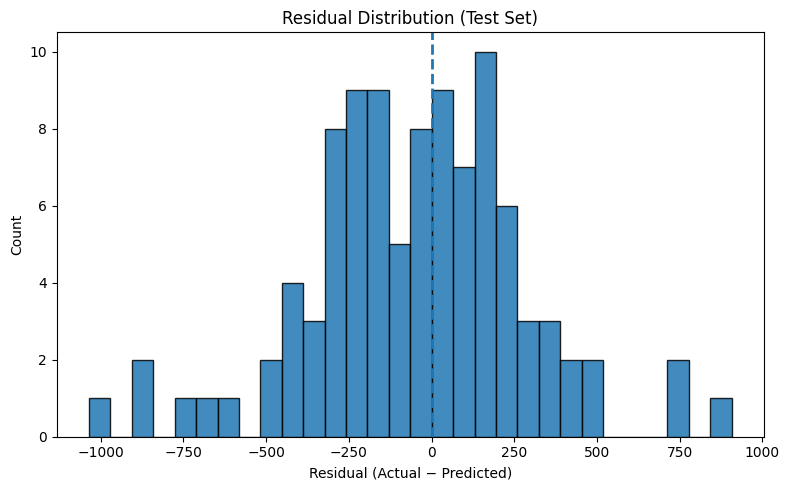

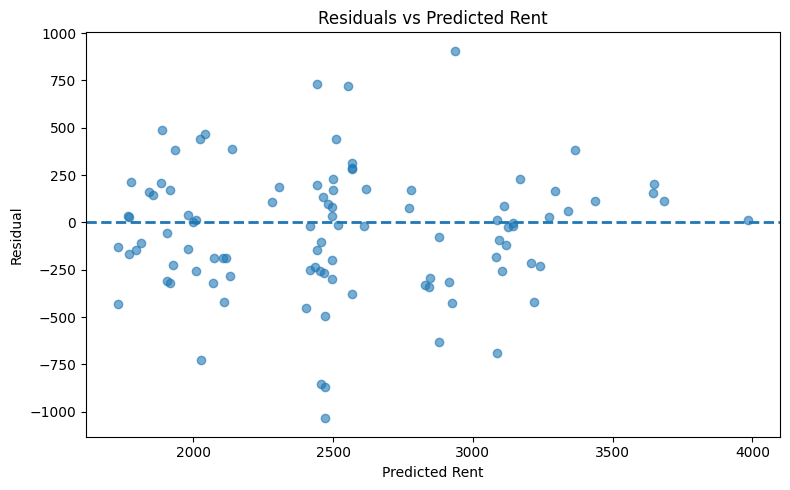

T-statistic: -1.537
P-value:     0.1276


In [13]:
residuals = y_test - y_pred

# 1) Histogram
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=30, edgecolor="black", alpha=0.85)
plt.axvline(0, linestyle="--", linewidth=2)
plt.title("Residual Distribution (Test Set)")
plt.xlabel("Residual (Actual − Predicted)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2) Residuals vs predicted
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, linestyle="--", linewidth=2)
plt.title("Residuals vs Predicted Rent")
plt.xlabel("Predicted Rent")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

# 3) Bias hypothesis test (mean residual = 0?)
t_stat, p_value = stats.ttest_1samp(residuals, 0)
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value:     {p_value:.4f}")


**Interpretation:** if the p-value is greater than 0.05, we fail to reject H₀ and conclude that the model is **unbiased on average**.


## 11) Prediction Helper (User-Friendly)


This helper function:
- validates inputs (reasonable ranges)
- computes engineered features
- predicts rent
- returns a simple uncertainty range using CV MAE


In [14]:
RANGES = {
    "Bedrooms": (0, 5),
    "Bathrooms": (1, 4),
    "Square_Feet": (300, 3500)
}

def _range_check(name, value, lo, hi):
    if value < lo or value > hi:
        return f"{name}={value:,.0f} is out of range. Allowed: [{lo:,} – {hi:,}]."
    return None

def predict_rent_user_friendly(model, cv_mae, bedrooms, bathrooms, sqft,
                               laundry_type, location_zone, parking_type,
                               strict=True):
    bedrooms = float(bedrooms)
    bathrooms = float(bathrooms)
    sqft = float(sqft)

    issues = [
        _range_check("Bedrooms", bedrooms, *RANGES["Bedrooms"]),
        _range_check("Bathrooms", bathrooms, *RANGES["Bathrooms"]),
        _range_check("Square_Feet", sqft, *RANGES["Square_Feet"]),
    ]
    issues = [x for x in issues if x is not None]

    if issues and strict:
        return {"status":"rejected", "message":"\n".join(issues), "allowed_ranges":RANGES}

    # clip if not strict
    if issues and not strict:
        bedrooms = np.clip(bedrooms, *RANGES["Bedrooms"])
        bathrooms = np.clip(bathrooms, *RANGES["Bathrooms"])
        sqft = np.clip(sqft, *RANGES["Square_Feet"])

    # engineered features (leakage-safe)
    room_ratio = bedrooms / (bathrooms + 0.001)
    size_per_bedroom = sqft / (bedrooms if bedrooms > 0 else 1)

    # Build a single-row dataframe matching training schema
    row = {
        "Bedrooms": bedrooms,
        "Bathrooms": bathrooms,
        "Square_Feet": sqft,
        "Laundry_Type": laundry_type,
        "Location_Zone": location_zone,
        "Parking": parking_type,
        "Room_Ratio": room_ratio,
        "Size_per_Bedroom": size_per_bedroom,
    }
    # Include Luxury_Flag only if model expects it
    if "Luxury_Flag" in feature_cols:
        row["Luxury_Flag"] = int((laundry_type == "In-unit") and (parking_type == "Included"))

    X_new = pd.DataFrame([row])

    pred = float(model.predict(X_new)[0])

    # simple uncertainty band using CV MAE mean
    half = float(np.mean(cv_mae))
    return {
        "status":"ok",
        "predicted_rent": int(np.round(pred/10)*10),
        "expected_range": (
            int(np.round((pred-half)/10)*10),
            int(np.round((pred+half)/10)*10)
        )
    }


In [15]:
example = predict_rent_user_friendly(
    model=rf_regularized,
    cv_mae=cv_mae,
    bedrooms=2,
    bathrooms=1,
    sqft=900,
    laundry_type="In-unit",
    location_zone="South_East",
    parking_type="Included",
)
example


{'status': 'ok', 'predicted_rent': 2740, 'expected_range': (2470, 3010)}

## 12) Save Outputs (CSV)


We save two user-friendly CSV files:
- `model_comparison.csv` (benchmark table)
- `final_predictions_sample.csv` (sample predictions)


In [ ]:
# # 1) model comparison
# model_comp_path = os.path.join(OUTPUT_DIR, "model_comparison.csv")
# results_df.to_csv(model_comp_path, index=False)

# # 2) sample predictions
# sample_df = df[feature_cols + ["Rent_Price_USD"]].sample(10, random_state=42).copy()
# sample_df["Predicted_Rent_USD"] = rf_regularized.predict(sample_df[feature_cols])
# sample_df["Absolute_Error_USD"] = (sample_df["Predicted_Rent_USD"] - sample_df["Rent_Price_USD"]).abs()

# pred_path = os.path.join(OUTPUT_DIR, "final_predictions_sample.csv")
# sample_df.to_csv(pred_path, index=False)

# print("Saved:")
# print(model_comp_path)
# print(pred_path)


## 13) Save Artifacts (Deployable Model + Metadata)


Because the final model is a **Pipeline**, we save **one object** that contains:
- imputers
- one-hot encoder
- the trained Random Forest

We also save:
- schema / feature list
- metrics summary (real CV + test metrics)


In [ ]:
# import joblib
# import json
# from datetime import datetime

# MODEL_PATH = os.path.join(ARTIFACT_DIR, "random_forest_pipeline.joblib")
# joblib.dump(rf_regularized, MODEL_PATH)

# feature_schema = {
#     "required_inputs": ["Bedrooms", "Bathrooms", "Square_Feet", "Laundry_Type", "Location_Zone", "Parking"],
#     "engineered_features_auto": ["Room_Ratio", "Size_per_Bedroom"] + (["Luxury_Flag"] if "Luxury_Flag" in feature_cols else []),
#     "feature_cols_used": feature_cols
# }

# SCHEMA_PATH = os.path.join(ARTIFACT_DIR, "feature_schema.json")
# with open(SCHEMA_PATH, "w", encoding="utf-8") as f:
#     json.dump(feature_schema, f, indent=4)

# metrics_summary = {
#     "model": "RandomForestRegressor (regularized) + OneHotEncoder Pipeline",
#     "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
#     "cross_validation": {
#         "cv_folds": 5,
#         "MAE_mean_usd": round(float(cv_mae.mean()), 2),
#         "MAE_std_usd": round(float(cv_mae.std()), 2),
#         "RMSE_mean_usd": round(float(cv_rmse.mean()), 2),
#         "RMSE_std_usd": round(float(cv_rmse.std()), 2),
#         "R2_mean": round(float(cv_r2.mean()), 4),
#         "R2_std": round(float(cv_r2.std()), 4),
#     },
#     "test_set": {
#         "MAE_usd": round(float(test_mae), 2),
#         "RMSE_usd": round(float(test_rmse), 2),
#         "R2": round(float(test_r2), 4),
#     }
# }

# METRICS_PATH = os.path.join(ARTIFACT_DIR, "metrics_summary.json")
# with open(METRICS_PATH, "w", encoding="utf-8") as f:
#     json.dump(metrics_summary, f, indent=4)

# print("Saved artifacts:")
# print(MODEL_PATH)
# print(SCHEMA_PATH)
# print(METRICS_PATH)


## 14) Save Clean Dataset (Reproducibility)


We save a **clean, human-readable** dataset that represents the model inputs **before encoding**.  
(Encoding happens inside the pipeline.)


In [16]:
clean_cols = [c for c in feature_cols + ["Rent_Price_USD"] if c in df.columns]
df_clean = df[clean_cols].copy()

clean_path = os.path.join(DATA_DIR, "bloomfield_rent_clean.csv")
df_clean.to_csv(clean_path, index=False)

print("Saved clean data:", clean_path)


Saved clean data: C:\Users\19173\Desktop\bloonfield rental apartement price forecasting\derneire 2\Bloomfield-Rental-Price-Forecasting 2\data\bloomfield_rent_clean.csv
